This notebook shows the yelp dataset start rating classification problem.
The objective is to predict the star rating based on the:
- business review count
- total number of checkins
- state where business is located
- city where business is located

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

In [2]:
df_business = pd.read_json('../../data/business.json',lines=True)
df_checkin = pd.read_json('../../data/checkin.json', lines=True)

## 2. Exploratory Data Analysis (EDA)

In [3]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
address         192609 non-null object
attributes      163773 non-null object
business_id     192609 non-null object
categories      192127 non-null object
city            192609 non-null object
hours           147779 non-null object
is_open         192609 non-null int64
latitude        192609 non-null float64
longitude       192609 non-null float64
name            192609 non-null object
postal_code     192609 non-null object
review_count    192609 non-null int64
stars           192609 non-null float64
state           192609 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


In [4]:
df_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


In [5]:
df_business = df_business.dropna()

In [6]:
df_business['review_count'] = df_business['review_count'].fillna(0)

In [7]:
df_business['stars'] = df_business['stars'].fillna(0)

In [8]:
df_business.describe()

,is_open,latitude,longitude,review_count,stars
count,129268.000000,129268.000000,129268.000000,129268.000000,129268.000000
mean,0.843565,38.348179,-97.976657,44.508370,3.712644
std,0.363268,4.867658,16.625511,131.780404,0.934989
min,0.000000,33.204642,-115.477519,3.000000,1.000000
25%,1.000000,33.625583,-112.272915,6.000000,3.000000
50%,1.000000,36.127674,-111.790583,13.000000,4.000000
75%,1.000000,43.112978,-80.037140,36.000000,4.500000
max,1.000000,51.296592,-72.945050,8348.000000,5.000000


In [9]:
stars = df_business.groupby('stars').mean()

In [10]:
stars.corr()

,is_open,latitude,longitude,review_count
is_open,1.000000,-0.886744,-0.864017,-0.575509
latitude,-0.886744,1.000000,0.995357,0.413856
longitude,-0.864017,0.995357,1.000000,0.366235
review_count,-0.575509,0.413856,0.366235,1.000000


In [11]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 1 to 192608
Data columns (total 14 columns):
address         129268 non-null object
attributes      129268 non-null object
business_id     129268 non-null object
categories      129268 non-null object
city            129268 non-null object
hours           129268 non-null object
is_open         129268 non-null int64
latitude        129268 non-null float64
longitude       129268 non-null float64
name            129268 non-null object
postal_code     129268 non-null object
review_count    129268 non-null int64
stars           129268 non-null float64
state           129268 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 14.8+ MB


In [11]:
numeric_features = df_business.loc[:, ['latitude', 'longitude', 'review_count', 'stars']]

In [12]:
numeric_features_standardized = (numeric_features)/numeric_features.max()

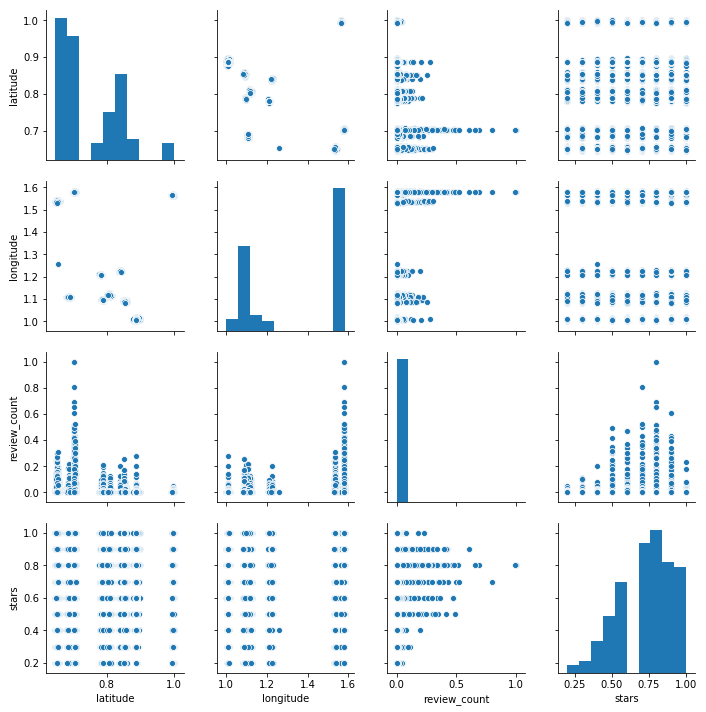

In [13]:
ax = sns.pairplot(numeric_features_standardized)
plt.show()

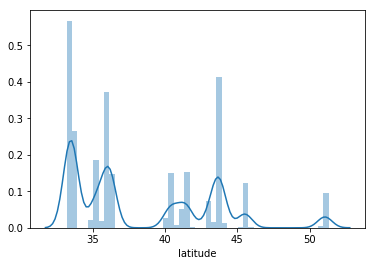

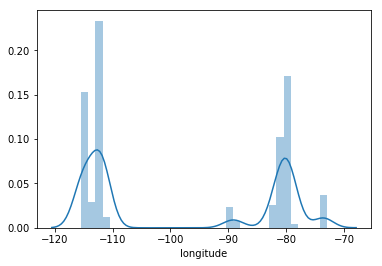

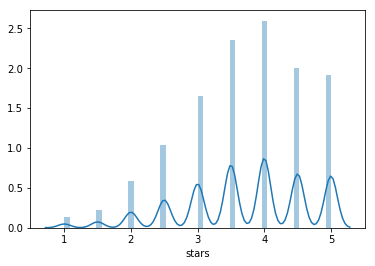

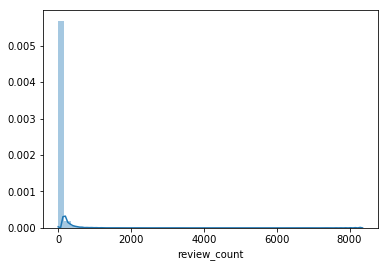

In [14]:
ax = sns.distplot(df_business['latitude'])
plt.show()
ax = sns.distplot(df_business['longitude'])
plt.show()
ax = sns.distplot(df_business['stars'])
plt.show()
ax = sns.distplot(df_business['review_count'])
plt.show()

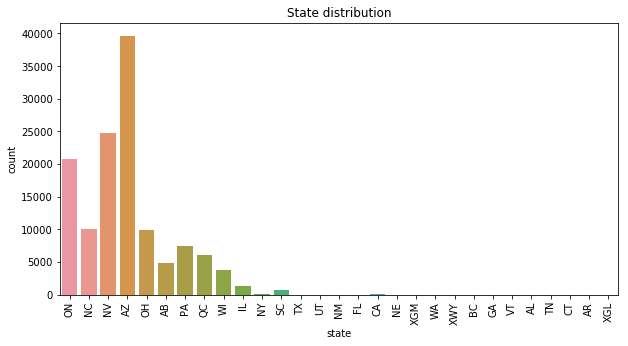

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='state', data=df_business)
plt.xticks(rotation='vertical')
plt.title('State distribution')
plt.show()

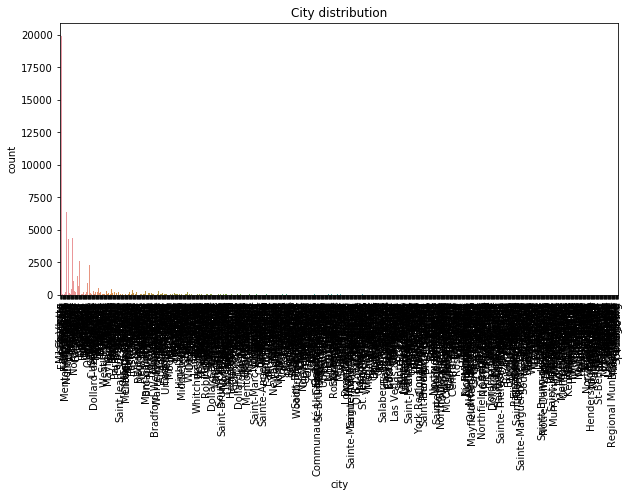

In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='city', data=df_business)
plt.xticks(rotation='vertical')
plt.title('City distribution')
plt.show()

In [15]:
df_business["stars"].value_counts()

4.0    26830
3.5    24301
4.5    20761
5.0    19854
3.0    17020
2.5    10756
2.0     6033
1.5     2258
1.0     1455
Name: stars, dtype: int64

In [16]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161950 entries, 0 to 161949
Data columns (total 2 columns):
business_id    161950 non-null object
date           161950 non-null object
dtypes: object(2)
memory usage: 2.5+ MB


In [17]:
df_checkin.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [19]:
#from datetime import datetime
#datetime_object = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [18]:
def get_checkin_count(x):
    return len(x.split(", "))

df_checkin['checkin_count'] = df_checkin['date'].apply(get_checkin_count)

In [19]:
df_checkin.head()

,business_id,date,checkin_count
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016...",6
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012...",167
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015...",180
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30,1
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010...",37


In [20]:
len(df_checkin["checkin_count"].unique())

2884

## 3. Prepare Data

In [21]:
df_merged = pd.merge(df_business, df_checkin, on='business_id', how='left')

In [22]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
state            129268 non-null object
date             113701 non-null object
checkin_count    113701 non-null float64
dtypes: float64(4), int64(2), object(10)
memory usage: 16.8+ MB


In [23]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.0
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.0
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC,NaN,NaN
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.0
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.0


In [24]:
df_merged[['checkin_count']] = df_merged[['checkin_count']].fillna(0)

In [25]:
df_merged.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,date,checkin_count
0,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON,"2010-07-05 16:56:31, 2010-12-21 20:30:01, 2010...",455.0
1,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC,"2010-11-13 01:00:36, 2010-12-19 00:49:15, 2011...",721.0
2,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC,NaN,0.0
3,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': '{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",1,43.599475,-79.711584,The UPS Store,L5V 0B1,3,2.5,ON,"2014-03-31 21:46:17, 2015-01-27 19:05:03, 2018...",3.0
4,"4545 E Tropicana Rd Ste 8, Tropicana","{'RestaurantsPriceRange2': '3', 'GoodForKids':...",gbQN7vr_caG_A1ugSmGhWg,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Las Vegas,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",1,36.099872,-115.074574,Supercuts,89121,3,3.5,NV,"2011-05-21 22:20:31, 2011-10-05 21:34:47, 2012...",11.0


In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 16 columns):
address          129268 non-null object
attributes       129268 non-null object
business_id      129268 non-null object
categories       129268 non-null object
city             129268 non-null object
hours            129268 non-null object
is_open          129268 non-null int64
latitude         129268 non-null float64
longitude        129268 non-null float64
name             129268 non-null object
postal_code      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
state            129268 non-null object
date             113701 non-null object
checkin_count    129268 non-null float64
dtypes: float64(4), int64(2), object(10)
memory usage: 16.8+ MB


In [27]:
df_merged_new = df_merged[['business_id','review_count', 'stars', 'checkin_count', 'city', 'state', 'categories']]
df_merged_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 7 columns):
business_id      129268 non-null object
review_count     129268 non-null int64
stars            129268 non-null float64
checkin_count    129268 non-null float64
city             129268 non-null object
state            129268 non-null object
categories       129268 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 7.9+ MB


In [28]:
df_merged_new['stars'] = df_merged_new['stars'].round()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
df_merged_new['stars'].value_counts()

4.0    71892
5.0    19854
2.0    19047
3.0    17020
1.0     1455
Name: stars, dtype: int64

In [30]:
df_merged_new['review_count'] = df_merged_new['review_count'].fillna(0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 4. Train Models

#### Normalize numeric features

In [31]:
from sklearn.preprocessing import StandardScaler

cols_to_norm = ['review_count', 'checkin_count']
#new_df[cols_to_norm] = new_df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

dict_scaler = {}
for col_to_norm in cols_to_norm:
    scaler = StandardScaler()
    scaler.fit(df_merged_new.loc[:, col_to_norm].values.reshape(-1, 1))
    df_merged_new.loc[:,col_to_norm] = scaler.transform(df_merged_new.loc[:,col_to_norm].values.reshape(-1, 1))
    dict_scaler[col_to_norm] = scaler  

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

#### Transform features of types string to integer

In [36]:
from sklearn import preprocessing

cols_str_to_int = ['state', 'city']
for col_str_to_int in cols_str_to_int:
    label_encoder = preprocessing.LabelEncoder()
    df_merged_new[col_str_to_int] = label_encoder.fit_transform(df_merged_new[col_str_to_int])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories
0,QXAEGFB4oINsVuTFxEYKFQ,0.633569,2.0,0.398021,481,16,"Specialty Food, Restaurants, Dim Sum, Imported..."
1,gnKjwL_1w79qoiV3IC_xQQ,0.952282,4.0,0.726081,129,10,"Sushi Bars, Restaurants, Japanese"
2,HhyxOkGAM07SRYtlQ4wMFQ,-0.307394,4.0,-0.163135,129,10,"Plumbing, Shopping, Local Services, Home Servi..."
3,68dUKd8_8liJ7in4aWOSEA,-0.314983,2.0,-0.159435,481,16,"Shipping Centers, Couriers & Delivery Services..."
4,gbQN7vr_caG_A1ugSmGhWg,-0.314983,4.0,-0.149568,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai..."


In [38]:
df_merged_new['categories_str'] = df_merged_new['categories'].apply(lambda x:x.replace(',', ''))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_merged_new.head()

,business_id,review_count,stars,checkin_count,city,state,categories,categories_str
0,QXAEGFB4oINsVuTFxEYKFQ,0.633569,2.0,0.398021,481,16,"Specialty Food, Restaurants, Dim Sum, Imported...",Specialty Food Restaurants Dim Sum Imported Fo...
1,gnKjwL_1w79qoiV3IC_xQQ,0.952282,4.0,0.726081,129,10,"Sushi Bars, Restaurants, Japanese",Sushi Bars Restaurants Japanese
2,HhyxOkGAM07SRYtlQ4wMFQ,-0.307394,4.0,-0.163135,129,10,"Plumbing, Shopping, Local Services, Home Servi...",Plumbing Shopping Local Services Home Services...
3,68dUKd8_8liJ7in4aWOSEA,-0.314983,2.0,-0.159435,481,16,"Shipping Centers, Couriers & Delivery Services...",Shipping Centers Couriers & Delivery Services ...
4,gbQN7vr_caG_A1ugSmGhWg,-0.314983,4.0,-0.149568,366,13,"Hair Salons, Hair Stylists, Barbers, Men's Hai...",Hair Salons Hair Stylists Barbers Men's Hair S...


In [40]:
categories = set((', '.join(df_merged_new['categories'].tolist())).strip().split(', '))
len(categories)

1279

In [41]:
categories

{'Mobile Home Repair',
 'Condominiums',
 'Business Financing',
 'Car Dealers',
 'Ski & Snowboard Shops',
 "Children's Museums",
 'Taiwanese',
 'Well Drilling',
 'RV Repair',
 'Bounce House Rentals',
 '& Probates',
 'Active Life',
 'Editorial Services',
 'Scavenger Hunts',
 'Emergency Medicine',
 'Wills',
 'Cinema',
 'Specialty Food',
 'Sushi Bars',
 'Aquarium Services',
 'Placenta Encapsulations',
 'Sandblasting',
 'Lingerie',
 'Payroll Services',
 'Brasseries',
 'Passport & Visa Services',
 'Cycling Classes',
 'Cheese Tasting Classes',
 'Beach Equipment Rentals',
 'Art Museums',
 'Heating & Air Conditioning/HVAC',
 'Aerial Tours',
 'Trampoline Parks',
 'Henna Artists',
 'Motorcycle Repair',
 'Furniture Assembly',
 'Countertop Installation',
 'Debt Relief Services',
 'Newspapers & Magazines',
 'First Aid Classes',
 'Videographers',
 'Tanning',
 'Home Cleaning',
 'Department Stores',
 'Advertising',
 'Belgian',
 'Pita',
 'Emergency Rooms',
 'Musicians',
 'Lakes',
 'High Fidelity Audio E

#### TODO: one-hot encoding
Due to limited computational resource, the categorical feature one-hot encoding is put into the todo list.

#### Text feature extraction 
https://scikit-learn.org/stable/modules/feature_extraction.html
https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=100, min_df=2)
vectorizer.fit(categories)
print(vectorizer.vocabulary_)
print(vectorizer.idf_)

{'mobile': 54, 'home': 41, 'repair': 72, 'car': 13, 'dealers': 24, 'shops': 82, 'rv': 73, 'rentals': 71, 'services': 78, 'medicine': 53, 'food': 31, 'bars': 7, 'classes': 17, 'tasting': 88, 'equipment': 28, 'art': 3, 'tours': 91, 'parks': 57, 'artists': 4, 'motorcycle': 55, 'furniture': 32, 'installation': 46, 'cleaning': 18, 'stores': 85, 'auto': 6, 'beer': 8, 'dance': 22, 'halls': 39, 'glass': 34, 'shoe': 79, 'hair': 38, 'removal': 69, 'centers': 16, 'bike': 9, 'service': 77, 'supplies': 86, 'pool': 63, 'hot': 43, 'pet': 60, 'transportation': 93, 'music': 56, 'printing': 64, 'schools': 75, 'clubs': 21, 'care': 14, 'day': 23, 'boat': 10, 'houses': 44, 'delivery': 25, 'design': 26, 'real': 68, 'estate': 29, 'water': 97, 'insurance': 47, 'wine': 99, 'rental': 70, 'party': 58, 'private': 65, 'public': 67, 'security': 76, 'arts': 5, 'personal': 59, 'surgeons': 87, 'health': 40, 'sports': 83, 'cannabis': 12, 'law': 48, 'massage': 51, 'shopping': 81, 'clinics': 19, 'medical': 52, 'shop': 80

In [43]:
df_merged_new['categories_str'].values[0]

'Specialty Food Restaurants Dim Sum Imported Food Food Chinese Ethnic Food Seafood'

In [44]:
len(vectorizer.transform([df_merged_new['categories_str'].values[1]]).toarray()[0])

100

In [45]:
df_merged_new['categories_tfid'] = df_merged_new['categories_str'].apply(lambda x:vectorizer.transform([x]).toarray()[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


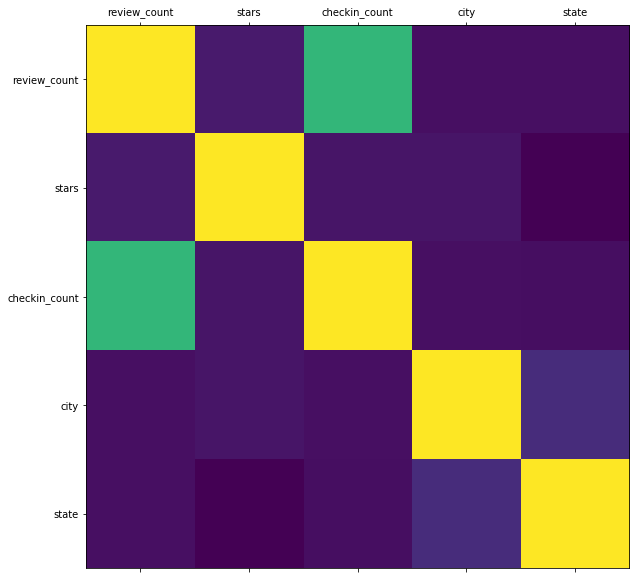

In [46]:
corr = df_merged_new.corr()

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);

plt.show()

### Predict star ratings without using category text features

In [47]:
X = df_merged_new[['review_count', 'checkin_count', 'city', 'state']]
Y = df_merged_new[['stars']]

X.info()
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 4 columns):
review_count     129268 non-null float64
checkin_count    129268 non-null float64
city             129268 non-null int64
state            129268 non-null int64
dtypes: float64(2), int64(2)
memory usage: 9.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 1 columns):
stars    129268 non-null float64
dtypes: float64(1)
memory usage: 7.0 MB


In [54]:
X.shape

(129268, 4)

In [56]:
X_tfid = df_merged_new[['review_count', 'checkin_count', 'city', 'state', 'categories_tfid']]

X_tfid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129268 entries, 0 to 129267
Data columns (total 5 columns):
review_count       129268 non-null float64
checkin_count      129268 non-null float64
city               129268 non-null int64
state              129268 non-null int64
categories_tfid    129268 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 10.9+ MB


In [69]:
for i in range(len(X_tfid.loc[0, 'categories_tfid'].tolist())):
    X_tfid['categories_tfid_{}'.format(i)] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [93]:
def f(x, i):
    return x[:][i]

for i in range(len(X_tfid.loc[0, 'categories_tfid'].tolist())):
    X_tfid['categories_tfid_{}'.format(i)] = X_tfid['categories_tfid'].apply(f, args=[i])

In [95]:
X_tfid.head()

,review_count,checkin_count,city,state,categories_tfid,categories_tfid_0,categories_tfid_1,categories_tfid_2,categories_tfid_3,categories_tfid_4,...,categories_tfid_90,categories_tfid_91,categories_tfid_92,categories_tfid_93,categories_tfid_94,categories_tfid_95,categories_tfid_96,categories_tfid_97,categories_tfid_98,categories_tfid_99
0,0.633569,0.398021,481,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.952282,0.726081,129,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,-0.307394,-0.163135,129,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355302,0.0,0.0
3,-0.314983,-0.159435,481,16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,-0.314983,-0.149568,366,13,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [96]:
X_tfid.columns

Index(['review_count', 'checkin_count', 'city', 'state', 'categories_tfid',
       'categories_tfid_0', 'categories_tfid_1', 'categories_tfid_2',
       'categories_tfid_3', 'categories_tfid_4',
       ...
       'categories_tfid_90', 'categories_tfid_91', 'categories_tfid_92',
       'categories_tfid_93', 'categories_tfid_94', 'categories_tfid_95',
       'categories_tfid_96', 'categories_tfid_97', 'categories_tfid_98',
       'categories_tfid_99'],
      dtype='object', length=105)

In [97]:
X_tfid.shape

(129268, 105)

In [46]:
#from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#X = scaler.fit_transform(X)

#scaler = StandardScaler()
#X_tfid = scaler.fit_transform(X_tfid)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [98]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_train_tfid, X_test_tfid, y_train, y_test = train_test_split(X_tfid, Y, test_size=0.3, random_state=42)

In [101]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_predict = random_forest.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test, y_predict))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


0.5675975348753255
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00       445
         2.0       0.00      0.00      0.00      5794
         3.0       0.00      0.00      0.00      5129
         4.0       0.58      0.95      0.72     21547
         5.0       0.46      0.26      0.33      5866

   micro avg       0.57      0.57      0.57     38781
   macro avg       0.21      0.24      0.21     38781
weighted avg       0.39      0.57      0.45     38781



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
X_train_tfid.values

array([[-0.17080276370724454, -0.14463499288481452, 916, ..., 0.0, 0.0,
        0.0],
       [-0.2922173394453599, -0.15450146835773743, 658, ..., 0.0, 0.0,
        0.0],
       [-0.2694521064944633, -0.1520348494895067, 245, ..., 0.0, 0.0,
        0.0],
       ...,
       [-0.31498257239625654, -0.13476851741189158, 917, ..., 0.0, 0.0,
        0.0],
       [-0.22392164059267, -0.09036937778373838, 366, ..., 0.0, 0.0, 0.0],
       [-0.034211366001864744, -0.08913606834962302, 865, ..., 0.0, 0.0,
        0.0]], dtype=object)

In [107]:
X_train.values

array([[-1.70802764e-01, -1.44634993e-01,  9.16000000e+02,
         2.50000000e+01],
       [-2.92217339e-01, -1.54501468e-01,  6.58000000e+02,
         1.70000000e+01],
       [-2.69452106e-01, -1.52034849e-01,  2.45000000e+02,
         2.50000000e+01],
       ...,
       [-3.14982572e-01, -1.34768517e-01,  9.17000000e+02,
         1.00000000e+01],
       [-2.23921641e-01, -9.03693778e-02,  3.66000000e+02,
         1.30000000e+01],
       [-3.42113660e-02, -8.91360683e-02,  8.65000000e+02,
         1.60000000e+01]])

In [106]:
random_forest = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
random_forest.fit(X_train_tfid.values, y_train)

y_predict = random_forest.predict(X_test_tfid)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

pd.DataFrame(confusion_matrix(y_test, y_predict))

print(classification_report(y_test, y_predict))

ValueError: setting an array element with a sequence.

In [51]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = neigh.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict)
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.4354967638792192


,0,1,2,3,4
0,28,120,40,158,99
1,126,1391,581,3151,545
2,51,1107,554,3071,346
3,280,4163,2015,13546,1543
4,204,1280,530,2482,1370


In [52]:
from sklearn.linear_model import RidgeClassifier
ridge = RidgeClassifier(alpha=1.0, solver='auto')
ridge.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = ridge.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict)
)

0.5556071272014647


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:839: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,1,2,3,4
0,0,0,0,445,0
1,0,0,0,5794,0
2,0,0,0,5129,0
3,0,0,0,21547,0
4,0,0,0,5866,0


In [53]:
from sklearn.neural_network import MLPClassifier
neural = MLPClassifier(hidden_layer_sizes=(100, ), activation='logistic', alpha=0.001, learning_rate='adaptive')
neural.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = neural.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict)
)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5651478816946442


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,0,1,2,3,4
0,0,0,0,340,105
1,0,0,0,5361,433
2,0,0,0,4924,205
3,0,0,0,20483,1064
4,0,0,0,4432,1434


In [54]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = clf.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict)
)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5556071272014647


,0,1,2,3,4
0,0,0,0,445,0
1,0,0,0,5794,0
2,0,0,1,5128,0
3,0,0,1,21546,0
4,0,0,0,5866,0


In [55]:
!pip install xgboost

    100% |████████████████████████████████| 114.0MB 384kB/s eta 0:00:01 5% |█▊                              | 6.0MB 15.2MB/s eta 0:00:08    11% |███▋                            | 12.8MB 39.9MB/s eta 0:00:03    12% |████                            | 14.2MB 45.1MB/s eta 0:00:03    20% |██████▌                         | 23.3MB 35.3MB/s eta 0:00:03    21% |███████                         | 24.7MB 43.6MB/s eta 0:00:03    32% |██████████▍                     | 37.2MB 45.5MB/s eta 0:00:02    34% |███████████                     | 39.5MB 36.6MB/s eta 0:00:03    35% |███████████▌                    | 40.9MB 47.1MB/s eta 0:00:02    40% |█████████████                   | 46.0MB 26.2MB/s eta 0:00:03    43% |██████████████                  | 50.0MB 25.9MB/s eta 0:00:03


In [56]:
import xgboost as xgb

clf = xgb.XGBClassifier(max_depth=4, n_estimators=200, learning_rate=0.05)
clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_predict = clf.predict(X_test)
accuracy_score = accuracy_score(y_test, y_predict)
print(accuracy_score)

from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict)
)


/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5692736133673706


,0,1,2,3,4
0,0,5,0,309,131
1,0,7,1,5319,467
2,0,1,0,4875,253
3,0,7,4,20327,1209
4,0,0,0,4123,1743


### Predict star ratings with using category text features

### Hyperparameter Tuning